## Sandbox for Implementing RetinaNet

- start wih pretrined resnet50, maybe from the original paper, or mybe from fastai, doesn't really matter
- then add feature pyramid network and finetune for coco

## General Approach

1. Download CamVid
- Build and train U-Net
- Download COCO
- Build Feature Pyramid Network (FPN) with ResNet backbone
- Build and train RetinaNet with FPN and object detection subnets

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.vision import *
from fastai.datasets import *
from fastai.callbacks import *
from fastai.utils.ipython import *

## CamVid

In [16]:
path = untar_data(URLs.CAMVID_TINY)
path_lbl = path/'labels'
path_img = path/'images'
codes = np.loadtxt(path/'codes.txt', dtype=str)
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

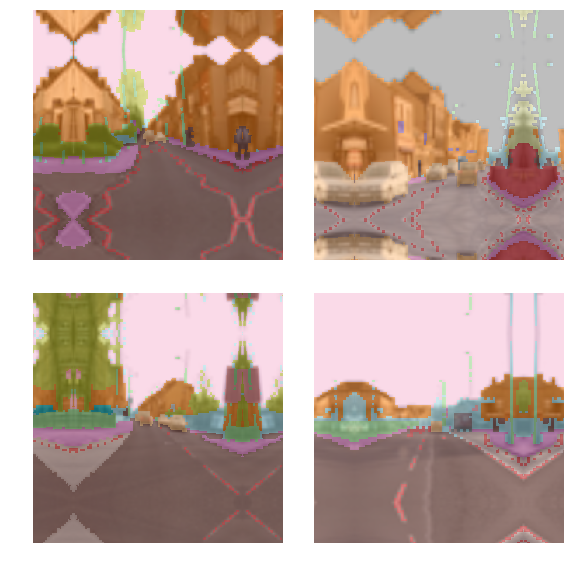

In [17]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'
tfms = get_transforms(xtra_tfms=[crop(size=388)])
data = (SegmentationItemList.from_folder(path_img)
        .split_by_rand_pct()
        .label_from_func(get_y_fn, classes=codes)
        .transform(tfms, tfm_y=True, size=572)
        .databunch(bs=8))
data.show_batch(2)

## U-Net

In [24]:
class Print(nn.Module):
    def forward(self, x):
        print(x.shape)
        return x


class Flatten(nn.Module):
    def forward(self, x): return x.view(x.shape[0], -1)    

In [45]:
class SaveMap():
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_fn)
        
    def hook_fn(self, module, input, output): self.map = output
    def remove(self): self.hook.remove()
        
        
@dataclass
class DumpMaps(LearnerCallback):
    learn: Learner
    def on_train_end(self, **kwargs):
        self.learn.model.close()

        
@dataclass
class SqueezeTarget(LearnerCallback):
    learn: Learner
    def on_batch_begin(self, **kwargs):
        crop = (kwargs['last_input'].shape[-1]-388) // 2
        cropped = kwargs['last_target'][:, :, crop:-crop, crop:-crop].squeeze(1)
        return {'last_target': cropped}

In [46]:
def conv(ic, oc, k=3, s=1, p=0, actn=True):
    layers = [nn.Conv2d(ic, oc, k, stride=s, padding=p)]
    if actn: layers.append(nn.ReLU(True))
    return nn.Sequential(*layers).cuda()


def conv_block(ic, oc, transpose=False, maxpool=True): 
    layers = [conv(ic, oc), conv(oc, oc)]
    if transpose: layers.append(nn.ConvTranspose2d(oc, oc//2, 2, stride=2))
    if maxpool: layers.append(nn.MaxPool2d(2, stride=2))
    return nn.Sequential(*layers).cuda()


def unet_down(cs): 
    layers = [conv_block(cs[i], cs[i+1]) for i in range(len(cs)-2)]
    layers.append(conv_block(cs[-2], cs[-1], maxpool=False))
    return nn.Sequential(*layers).cuda()


def unet_up(x, maps, classes):
    cs = [m.map.shape[1] for m in maps]
    sz = x.shape[-1]*2
    x = nn.ConvTranspose2d(cs[0], cs[0]//2, 2, stride=2).cuda()(x)
    for i in range(len(cs)-1):
        crop = (maps[i+1].map.shape[-1] - sz) // 2
        cropped = maps[i+1].map[:, :, crop:-crop, crop:-crop]
        x = torch.cat((cropped, x), 1)
#         x = torch.cat((maps[i+1].map, x), 1)
        if (len(cs)-1-i) == 1:
            x = conv_block(cs[i], cs[i+1], transpose=False, maxpool=False)(x)
        else:
            x = conv_block(cs[i], cs[i+1], transpose=True, maxpool=False)(x)
        sz = x.shape[-1]
    return conv(cs[-1], classes, k=1, actn=False)(x)

In [47]:
class UNet(nn.Module):
    def __init__(self, backbone, classes):
        super().__init__()
        self.backbone = backbone
        self.classes = classes
        self.maps = [SaveMap(block[-2]) for block in children(backbone)]
        self.maps.reverse()
        
    def forward(self, x): return unet_up(self.backbone(x), self.maps, self.classes)
    def close(self): 
        for mp in self.maps: mp.remove()

In [52]:
cs = [3, 64, 128, 256, 512, 1024]
backbone, classes = unet_down(cs), len(data.classes)
model = UNet(backbone, classes)

In [53]:
learn = Learner(data, 
                model, 
                metrics=accuracy, 
                opt_func=torch.optim.SGD, 
                loss_func=F.cross_entropy,
                callback_fns=[SqueezeTarget, DumpMaps, ShowGraph])
learn.init(nn.init.kaiming_normal_)
with gpu_mem_restore_ctx():
    learn.lr_find()

Traceback (most recent call last):
  File "/home/sudosharma/miniconda3/envs/wilbur/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/sudosharma/miniconda3/envs/wilbur/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/sudosharma/miniconda3/envs/wilbur/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/sudosharma/miniconda3/envs/wilbur/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/sudosharma/miniconda3/envs/wilbur/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/sudosharma/miniconda3/envs/wilbur/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/h

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


KeyboardInterrupt: 

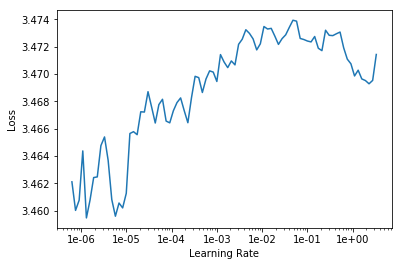

In [50]:
learn.recorder.plot()